# PFCS data

## Init

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PFCS.scripts.gt_plot import read_data
from pathlib import Path
from collections import OrderedDict
# from sktime.clustering.dbscan import TimeSeriesDBSCAN
# from sklearn.metrics.pairwise import pairwise_distances
# from sklearn import metrics
# from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
from claspy.data_loader import load_has_dataset
from claspy.segmentation import BinaryClaSPSegmentation

In [3]:
from aeon.segmentation import HidalgoSegmenter, GreedyGaussianSegmenter
from aeon.visualisation.learning_task._segmentation import (
    plot_series_with_change_points,
)
from aeon.visualisation.series._series import plot_series

In [4]:
import ruptures as rpt

In [5]:
# %matplotlib ipympl

## Get data + preprocessing

In [6]:
task_ground_truth = [
    {
        "filename": "fetch_recorded_demo_1730997119",
        "idx": OrderedDict({
            "plate": {"ini": 0, "end": 1125},
            "napkin": {"ini": 1125, "end": 2591},
            "cup": {"ini": 2591, "end": 3986},
            "fork": {"ini": 3986, "end": 5666},
            "spoon": {"ini": 5666, "end": 7338},
        }),
    },
    {
        "filename": "fetch_recorded_demo_1730997530",
        "idx": OrderedDict({
            "plate": {"ini": 0, "end": 1812},
            "napkin": {"ini": 1812, "end": 3844},
            "cup": {"ini": 3844, "end": 5732},
            "fork": {"ini": 5732, "end": 7090},
            "spoon": {"ini": 7090, "end": 7955},
        }),
    },
    {
        "filename": "fetch_recorded_demo_1730997735",
        "idx": OrderedDict({
            "plate": {"ini": 0, "end": 1965},
            "napkin": {"ini": 1965, "end": 4178},
            "cup": {"ini": 4178, "end": 6427},
            "spoon": {"ini": 6427, "end": 7904},
            "fork": {"ini": 7904, "end": 9123},
        }),
    },
    {
        "filename": "fetch_recorded_demo_1730997956",
        "idx": OrderedDict({
            "plate": {"ini": 0, "end": 1898},
            "napkin": {"ini": 1898, "end": 4081},
            "cup": {"ini": 4081, "end": 5442},
            "spoon": {"ini": 5442, "end": 6829},
            "fork": {"ini": 6829, "end": 9177},
        }),
    },
]

In [7]:
# # path = './PFCS/table task/xyz data/full_tasks/fetch_recorded_demo_1730997119.txt'
# xyz_path = Path("./PFCS/table task/xyz data/full_tasks/fetch_recorded_demo_1730997956.txt")
# # h5_path = './PFCS/table task/h5 files/fetch_recorded_demo_1730997119.h5'
# h5_path = Path("./PFCS/table task/h5 files/fetch_recorded_demo_1730997956.h5")

filenum = 0
datapath_root = Path("./PFCS/table task")
xyz_path = (
    datapath_root
    / "xyz data"
    / "full_tasks"
    / (task_ground_truth[filenum]["filename"] + ".txt")
)
h5_path = datapath_root / "h5 files" / (task_ground_truth[filenum]["filename"] + ".h5")

In [8]:
data = np.loadtxt(xyz_path)  # load the file into an array

# x = data[:, 0]
# y = data[:, 1]
# z = data[:, 2]

joint_data, tf_data, gripper_data = read_data(h5_path)
# time = tf_data[0][:, 0] + tf_data[0][:, 1] * (10.0 ** -9)

# traj_list = [x, y, z]
# traj = data
# traj.shape

In [9]:
# nanosec_conv = 1e-9
time_sec = tf_data[0][:, 0]
time_nanosec = tf_data[0][:, 1]
# time = time_sec + time_nanosec * nanosec_conv

In [10]:
timestamps = []
for t_idx, t_val in enumerate(time_sec):
    timestamp = pd.Timestamp(time_sec[t_idx], unit="s", tz="EST") + pd.to_timedelta(
        time_nanosec[t_idx], unit="ns"
    )
    timestamps.append(timestamp)
timestamps = pd.Series(timestamps)
timestamps

0      2024-11-07 11:31:59.503861904-05:00
1      2024-11-07 11:31:59.533841848-05:00
2      2024-11-07 11:31:59.553872347-05:00
3      2024-11-07 11:31:59.553872347-05:00
4      2024-11-07 11:31:59.583873749-05:00
                       ...                
7333   2024-11-07 11:34:42.413918734-05:00
7334   2024-11-07 11:34:42.443821907-05:00
7335   2024-11-07 11:34:42.473963261-05:00
7336   2024-11-07 11:34:42.503791571-05:00
7337   2024-11-07 11:34:42.523845196-05:00
Length: 7338, dtype: datetime64[ns, EST]

In [11]:
traj = pd.DataFrame(
    {"x": data[:, 0], "y": data[:, 1], "z": data[:, 2], "timestamps": timestamps}
)
traj

,x,y,z,timestamps
0,0.425767,0.243364,0.976381,2024-11-07 11:31:59.503861904-05:00
1,0.425373,0.243382,0.976542,2024-11-07 11:31:59.533841848-05:00
2,0.425282,0.243515,0.976639,2024-11-07 11:31:59.553872347-05:00
3,0.425282,0.243515,0.976639,2024-11-07 11:31:59.553872347-05:00
4,0.425350,0.243331,0.976105,2024-11-07 11:31:59.583873749-05:00
...,...,...,...,...
7333,0.662908,0.221483,1.031193,2024-11-07 11:34:42.413918734-05:00
7334,0.662635,0.221682,1.031233,2024-11-07 11:34:42.443821907-05:00
7335,0.662784,0.222090,1.030785,2024-11-07 11:34:42.473963261-05:00
7336,0.662740,0.221329,1.030948,2024-11-07 11:34:42.503791571-05:00


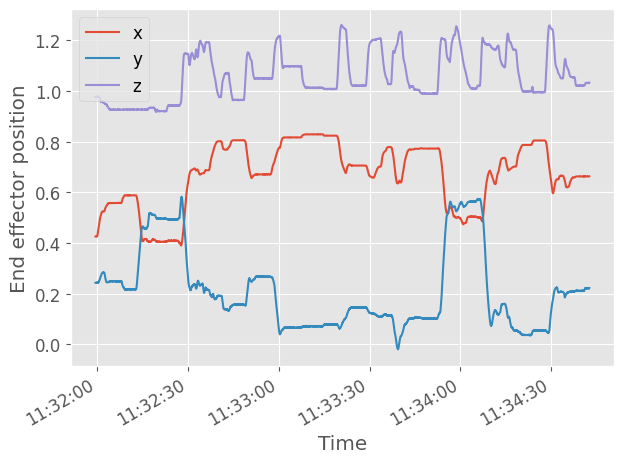

In [12]:
with plt.style.context("ggplot_perso.mplstyle"):
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    # cmap = mpl.colormaps.get("tab10").colors
    ax.plot(traj.timestamps, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamps, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamps, traj.z, label="z")  # , color=cmap[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [13]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#     fig.suptitle("End effector position")
#     ax.plot(traj.x, traj.y, traj.z)
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")
#     plt.show()

## Ground truth segmentation

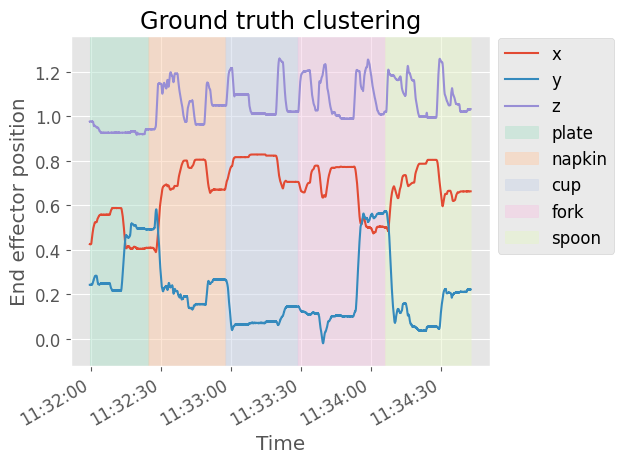

In [14]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(traj.timestamps, traj.x, label="x")  # , color=cmap[0])
    ax.plot(traj.timestamps, traj.y, label="y")  # , color=cmap[1])
    ax.plot(traj.timestamps, traj.z, label="z")  # , color=cmap[2])

    fill_min = np.min([traj.x.min(), traj.y.min(), traj.z.min()])
    fill_max = np.max([traj.x.max(), traj.y.max(), traj.z.max()])
    for sect_i, sect_key in enumerate(task_ground_truth[filenum]["idx"].keys()):
        sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]
        x = timestamps[sect_dict_current["ini"] : sect_dict_current["end"]]
        ax.fill_between(
            x=x,
            y1=fill_min,
            y2=fill_max,
            color=cmap[sect_i],
            alpha=0.5,
            transform=ax.get_xaxis_transform(),
            label=sect_key,
        )

    ax.set_ylim(bottom=fill_min - 0.1, top=fill_max + 0.1)
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(bbox_to_anchor=(1.0, 1.02))
    ax.set_title("Ground truth clustering")
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

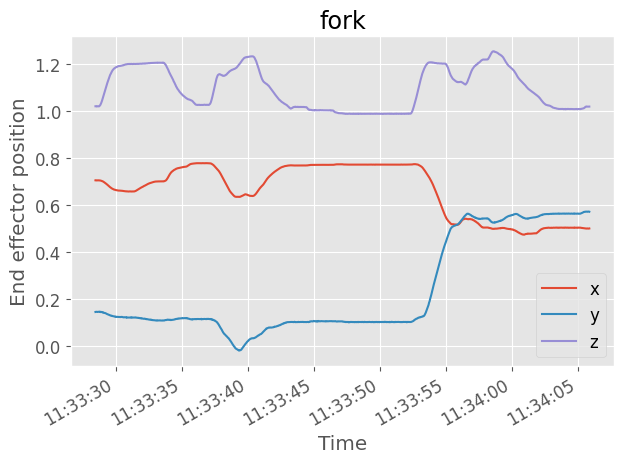

In [15]:
sect_key = "fork"
sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]

with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("Pastel2").colors
    ax.plot(
        traj.timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.x[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="x",
    )  # , color=cmap[0])
    ax.plot(
        traj.timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.y[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="y",
    )  # , color=cmap[1])
    ax.plot(
        traj.timestamps[sect_dict_current["ini"] : sect_dict_current["end"]],
        traj.z[sect_dict_current["ini"] : sect_dict_current["end"]],
        label="z",
    )  # , color=cmap[2])
    ax.set_xlabel("Time")
    ax.set_ylabel("End effector position")
    ax.legend(loc="best")
    ax.set_title(sect_key)
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.show()

In [16]:
traj.z[sect_dict_current["ini"] : sect_dict_current["end"]]

3986    1.020806
3987    1.020688
3988    1.020904
3989    1.019882
3990    1.019882
          ...   
5661    1.019099
5662    1.019349
5663    1.019303
5664    1.019392
5665    1.019392
Name: z, Length: 1680, dtype: float64

In [17]:
# with plt.style.context("ggplot_perso.mplstyle"):
#     cmap = mpl.colormaps.get("tab10").colors
#     fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#     fig.suptitle("End effector position")

#     for sect_i, sect_key in enumerate(task_ground_truth[filenum]["idx"].keys()):
#         sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]
#         ax.plot(
#             traj.x[sect_dict_current["ini"] : sect_dict_current["end"]],
#             traj.y[sect_dict_current["ini"] : sect_dict_current["end"]],
#             traj.z[sect_dict_current["ini"] : sect_dict_current["end"]],
#             color=cmap[sect_i],
#             label=sect_key,
#         )
#     ax.legend(loc="best")
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_zlabel("z")
#     fig.tight_layout()
#     plt.show()

## Segmentation

In [18]:
true_cps = np.ones((len(task_ground_truth[filenum]["idx"]) - 1)) * np.nan
for sect_i, sect_key in enumerate(task_ground_truth[filenum]["idx"].keys()):
    sect_dict_current = task_ground_truth[filenum]["idx"][sect_key]
    if sect_i < len(true_cps):
        true_cps[sect_i] = sect_dict_current["end"]
true_cps

array([1125., 2591., 3986., 5666.])

In [19]:
labels = task_ground_truth[filenum]["idx"].keys()
labels

odict_keys(['plate', 'napkin', 'cup', 'fork', 'spoon'])

In [20]:
X = traj.drop(columns=["timestamps"])
X

,x,y,z
0,0.425767,0.243364,0.976381
1,0.425373,0.243382,0.976542
2,0.425282,0.243515,0.976639
3,0.425282,0.243515,0.976639
4,0.425350,0.243331,0.976105
...,...,...,...
7333,0.662908,0.221483,1.031193
7334,0.662635,0.221682,1.031233
7335,0.662784,0.222090,1.030785
7336,0.662740,0.221329,1.030948


In [21]:
X_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
X_scaled

array([[0.08161856, 0.4366531 , 0.17522748],
       [0.08071961, 0.43668247, 0.17569776],
       [0.08051294, 0.43690475, 0.1759822 ],
       ...,
       [0.6217846 , 0.40128889, 0.33409857],
       [0.62168327, 0.40002427, 0.3345754 ],
       [0.62227178, 0.40137428, 0.33745205]], shape=(7338, 3))

### Multivariate ClaSP

In [22]:
clasp = BinaryClaSPSegmentation(n_segments=4)

In [23]:
pred = clasp.fit_predict(X_scaled)
pred

array([], dtype=float64)

In [24]:
if pred.size == 0:
    print("No segmentation classes found...")
else:
    clasp.plot(
        gt_cps=true_cps,
        heading=f"Segmentation of activity routine: {', '.join(labels)}",
        ts_name="ACC",
        font_size=18,
        file_path="test-multivariate-ClaSP.png"
    );

No segmentation classes found...


### Hidalgo

In [25]:
hidalgo = HidalgoSegmenter(K=len(labels), q=3, n_iter=2000, burn_in=0.8)

In [33]:
try:
    cps = hidalgo.fit_predict(X_scaled, axis=0)
    print("Found change points:", cps)
except AssertionError as ae:
    print("\nAssertion error bug...")

/home/kir0ul/Projects/segmentation-baselines/venv/lib64/python3.11/site-packages/aeon/segmentation/_hidalgo.py:176: RuntimeWarning: divide by zero encountered in divide
  mu = np.divide(distances[:, 2], distances[:, 1])
/home/kir0ul/Projects/segmentation-baselines/venv/lib64/python3.11/site-packages/aeon/segmentation/_hidalgo.py:176: RuntimeWarning: invalid value encountered in divide
  mu = np.divide(distances[:, 2], distances[:, 1])



Assertion error bug...


### GGS

In [27]:
ggs = GreedyGaussianSegmenter(k_max=len(labels), lamb=1, verbose=True)

In [28]:
cps = ggs.fit_predict(X_scaled, axis=0)
cps

array([0, 0, 0, ..., 5, 5, 5], shape=(7338,), dtype=int32)

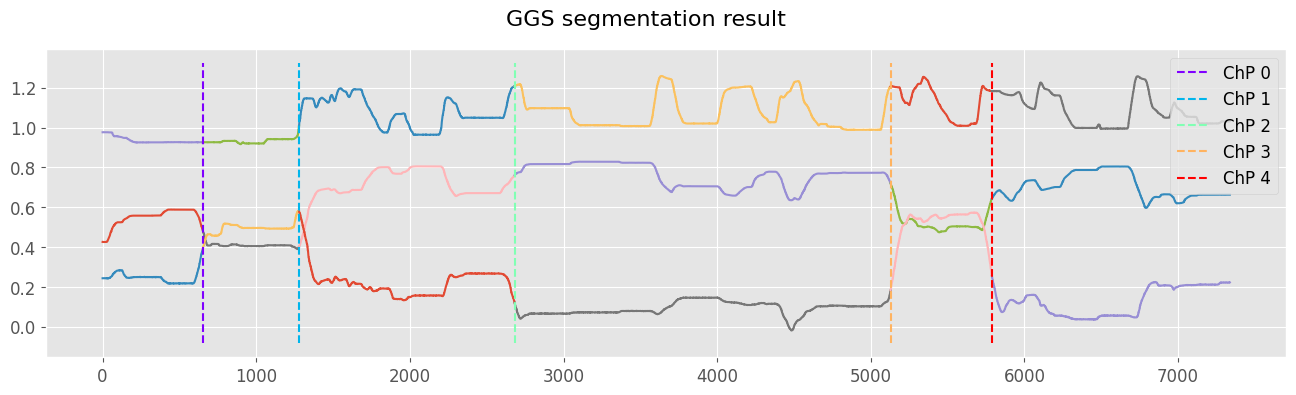

In [29]:
with plt.style.context("ggplot_perso.mplstyle"):
    fig, ax = plot_series_with_change_points(
        y=X,
        change_points=np.where(np.diff(cps) != 0)[0],
        title="GGS segmentation result",
        font_size=16,
    )
    plt.show()

### ruptures

In [30]:
bkps = [item["end"] for item in task_ground_truth[filenum]["idx"].values()]
bkps

[1125, 2591, 3986, 5666, 7338]

In [31]:
# detection
# algo = rpt.Pelt(model="rbf").fit(X_scaled)
algo = rpt.KernelCPD(kernel="rbf").fit(X_scaled)
result = algo.predict(pen=10)
print(result)

[np.int32(132), np.int32(648), np.int32(1284), np.int32(1343), np.int32(1725), np.int32(1998), np.int32(2217), np.int32(2310), np.int32(2639), np.int32(2738), np.int32(3053), np.int32(3593), np.int32(3735), np.int32(4026), np.int32(4254), np.int32(4410), np.int32(4562), np.int32(4622), np.int32(5090), np.int32(5148), np.int32(5191), np.int32(5275), np.int32(5420), np.int32(5493), np.int32(5706), np.int32(5760), np.int32(5798), np.int32(5984), np.int32(6083), np.int32(6258), np.int32(6696), np.int32(6752), np.int32(6816), np.int32(7058), 7338]


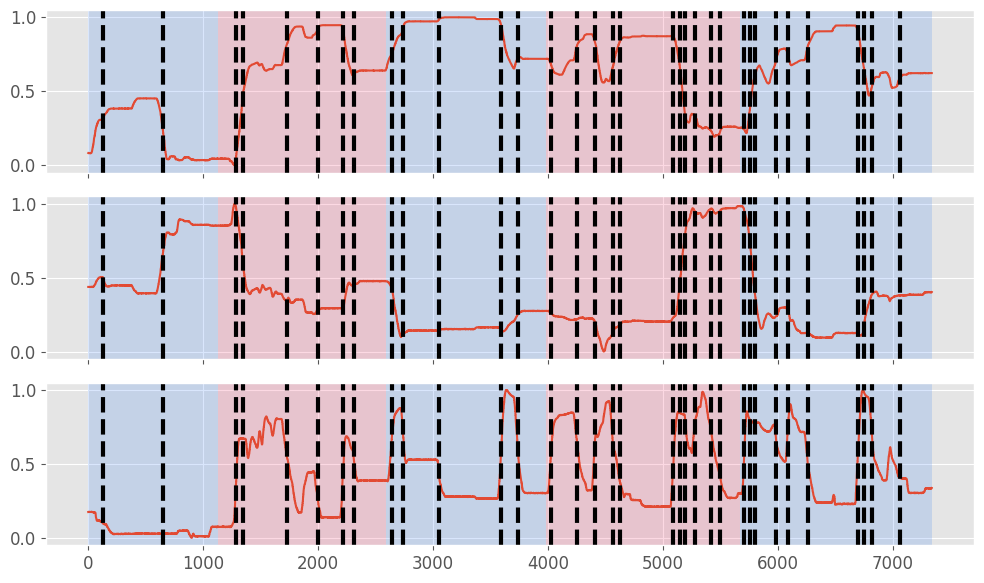

In [32]:
# display
with plt.style.context("ggplot_perso.mplstyle"):
    rpt.display(X_scaled, bkps, result)
    plt.show()